## Task 1: Theory (3pt)

At Lecture 12 we have discussed [Neural ODE](https://arxiv.org/pdf/1806.07366.pdf) model. There we used the adjoint state functions
$$
	\mathbf{a}_{\mathbf{z}}(t) = \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t)}; \quad \mathbf{a}_{\boldsymbol{\theta}}(t) = \frac{\partial L(\mathbf{y})}{\partial \boldsymbol{\theta}(t)}.
$$

These two functions allowed to derive continuous version of backpropagation algorithm.

The formulas for the method are given by Pontryagin theorem. It claims that
$$
	\frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt} = - \mathbf{a}_{\mathbf{z}}(t)^T \cdot \frac{\partial f(\mathbf{z}(t), \boldsymbol{\theta})}{\partial \mathbf{z}}; \quad \frac{d \mathbf{a}_{\boldsymbol{\theta}}(t)}{dt} = - \mathbf{a}_{\mathbf{z}}(t)^T \cdot \frac{\partial f(\mathbf{z}(t), \boldsymbol{\theta})}{\partial \boldsymbol{\theta}}.
$$

Your task here is to verify that the ODE for $\mathbf{a}_{\mathbf{z}}$ leads to the standard backpropagation algorithm for the ResNet block if we use discretization.

**Hints**: you have to use 2 facts

1. ResNet forward path: $\mathbf{z}(t + 1) = \mathbf{z}(t) + f(\mathbf{z}(t), \boldsymbol{\theta})$.

2. Finite difference approximation of the derivative (for $\varepsilon = 1$):
$$
    \frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt} \approx \frac{\mathbf{a}_{\mathbf{z}}(t + \varepsilon) - \mathbf{a}_{\mathbf{z}}(t)}{\varepsilon}
$$
3. Standard backpropagation based on the relation between $\frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t)}$ and $\frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t + 1)}$ (the relation is given by the chain rule).

$$
\mathbf{z}(t + \epsilon) = \mathbf{z}(t) + {\epsilon}f(\mathbf{z}(t), \boldsymbol{\theta}) \\
\frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t)} = \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t + \epsilon)} \cdot \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} = \frac{\partial L(\mathbf{y})}{\partial \mathbf{z}(t + \epsilon)} \cdot (\mathbb{I} + \epsilon \frac{\partial f(\mathbf{z}(t), \boldsymbol{\theta})}{\partial \mathbf{z}(t)})
$$

$$
\frac{d \mathbf{a}_{\mathbf{z}}(t)}{dt} = \lim_{\epsilon->0} \frac{\mathbf{a}_{\mathbf{z}}(t + \varepsilon) - \mathbf{a}_{\mathbf{z}}(t)}{\varepsilon} = \lim_{\epsilon->0} \frac{\mathbf{a}_{\mathbf{z}}(t + \varepsilon) - \mathbf{a}_{\mathbf{z}}(t+\epsilon)(\mathbb{I} + {\epsilon}\frac{\partial f(\mathbf{z}(t), \boldsymbol{\theta})}{\partial \boldsymbol{\theta}})}{\varepsilon} = -\mathbf{a}_{\mathbf{z}}(t)\frac{\partial f(\mathbf{z}(t), \boldsymbol{\theta})}{\partial \boldsymbol{\theta}}
$$

In [1]:
'''
REPO_NAME = "2022-DGM-Ozon-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}
'''

'\nREPO_NAME = "2022-DGM-Ozon-course"\n!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi\n!git clone https://github.com/r-isachenko/{REPO_NAME}.git\n!cd {REPO_NAME}\n!pip install ./{REPO_NAME}/homeworks/\n!rm -Rf {REPO_NAME}\n'

In [2]:
from dgm_utils import visualize_2d_samples, show_samples, visualize_images, load_pickle 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from torchvision.models import inception_v3

USE_CUDA = torch.cuda.is_available()

print('cuda is available:', USE_CUDA)

cuda is available: True


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# do not change this function
def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Task 2: SN-GAN on CIFAR10 (5pt)

Here you will train the [SN-GAN](https://arxiv.org/pdf/1802.05957.pdf) model to the CIFAR10 dataset.

Download the data from [here](https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing) (you could use the cell below).

In [6]:
'''
!gdown --id 16j3nrJV821VOkkuRz7aYam8TyIXLnNme
'''

'\n!gdown --id 16j3nrJV821VOkkuRz7aYam8TyIXLnNme\n'

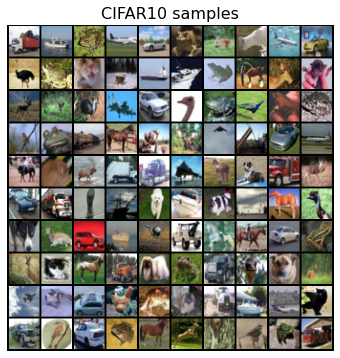

In [7]:
# train_data, test_data = load_pickle('/content/cifar10.pkl')
train_data, test_data = load_pickle('cifar10.pkl')
visualize_images(train_data, 'CIFAR10 samples')

Spectral Normalization GAN replaces the weights in the critic $f(\mathbf{x}, \boldsymbol{\phi})$ by 
$$
    \mathbf{W}^{SN} = \frac{\mathbf{W}}{\|\mathbf{W}\|_2}.
$$

This ensures that $\| f\|_L \leq 1.$.

Power iteration method allows to efficiently compute $\| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})}$.
    
The pseudocode of the method is:
* $\mathbf{u}_0$ -- random vector.
* for $k = 0, \dots, n - 1$: 
$$
    \mathbf{v}_{k+1} = \frac{\mathbf{W}^T \mathbf{u}_{k}}{\| \mathbf{W}^T \mathbf{u}_{k} \|}, \quad \mathbf{u}_{k+1} = \frac{\mathbf{W} \mathbf{v}_{k+1}}{\| \mathbf{W} \mathbf{v}_{k+1} \|}.
$$
* approximate the spectral norm
$$
    \| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})} \approx \mathbf{u}_{n}^T \mathbf{W} \mathbf{v}_{n}.
$$

First step is to implement this method.

In [9]:
def power_iteration_method(W, n_iters, u_init=None, v_init=None, eps = 1.e-10):
    if u_init is None:
        u_init = nn.Parameter(torch.randn(W.shape[0]), requires_grad=False)
    if v_init is None:
        v_init = nn.Parameter(torch.randn(W.shape[1]), requires_grad=False)
    
    # ====
    # your code
    # 1) implement for loop and update v_init/u_init
    # 2) calculate spectral norm
    # 3) return spectral norm (sigma) and the last values for v_init, u_init
    for i in range(n_iters):
        v_init  = torch.mv(W.t(), u_init)
        v_init /= torch.norm(v_init) + eps
        u_init  = torch.mv(W, v_init)
        u_init /= torch.norm(u_init) + eps
    
    if n_iters > 0:
        u_init = u_init.clone(memory_format=torch.contiguous_format)
        v_init = v_init.clone(memory_format=torch.contiguous_format)
    sigma = torch.dot(u_init, torch.mv(W, v_init))
    return sigma, u_init, v_init
    # ====
    return sigma, u_init, v_init


def test_power_iteration_method():
    W = np.array([
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]
    ], dtype=np.float32)
    U, S, V = np.linalg.svd(W)
    W_tensor = torch.tensor(W)
    sigma, u, v = power_iteration_method(W_tensor, n_iters=15)
    
    print(sigma, S[  0] )
    print(u    , U[:,0] )
    print(v    , V[0,:] )
       
    assert np.allclose(S[0], sigma)
    assert np.allclose(u, U[:, 0])
    assert np.allclose(v, V[0, :])


test_power_iteration_method()

tensor(9.6235) 9.623475
tensor([-0.3851, -0.5595, -0.7339]) [-0.38508978 -0.55951023 -0.73393065]
tensor([-0.3851, -0.5595, -0.7339]) [-0.38508978 -0.55951023 -0.73393065]


Now we need to define layers with Spectral Normalization (we will use Conv2D and Linear layers in out critic).

In [10]:
class SpectralNormConv2D(nn.Conv2d):
    def __init__(self, power_iterations=1, **kwargs):
        super().__init__(**kwargs)
        self.power_iterations = power_iterations
        self.u = nn.Parameter(torch.randn(self.weight.shape[0]), requires_grad=False)
        self.v = nn.Parameter(torch.randn(self.weight.shape[1]), requires_grad=False)
        
    def forward(self, input):
        W = self.weight.view(self.weight.shape[0], -1)
        # ====
        # your code
        # apply power iteration method
        with torch.no_grad():
            sigma, u, v = power_iteration_method(W, self.power_iterations, self.u, self.v)
        # ====
        self.u.data = u.data
        self.v.data = v.data
        self.weight.data = self.weight.data / sigma
        
        return super().forward(input)


class SpectralNormLinear(nn.Linear):
    def __init__(self, power_iterations=1, **kwargs):
        super().__init__(**kwargs)
        self.power_iterations = power_iterations
        
        self.u = nn.Parameter(torch.randn(self.weight.shape[0]), requires_grad=False)
        self.v = nn.Parameter(torch.randn(self.weight.shape[1]), requires_grad=False)
        
    def forward(self, input):
        W = self.weight.view(self.weight.shape[0], -1)
        # ====
        # your code
        # apply power iteration method
        with torch.no_grad():
            sigma, u, v = power_iteration_method(W, self.power_iterations, self.u, self.v)
        # ====
        self.u.data = u.data
        self.v.data = v.data
        self.weight.data = self.weight.data / sigma
        
        return super().forward(input)

We will use the similar convolutional generator to that we have used in hw5.

In [11]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size=128, n_channels=64):
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        # ====
        # your code
        # 1) define linear layer with output units 4 * 4 * 4 * n_channels, then relu
        # 2) define transposed conv with stride 2, kernel size 2 then BN, then relu
        # 3) define transposed conv with stride 2, kernel size 2 then BN, then relu
        self.linear_1 = nn.Linear     (self.input_size, 4 * 4 * 4*self.n_channels)
        self.bn_1     = nn.BatchNorm2d(4*self.n_channels)
        
        self.conv_t_2 = nn.ConvTranspose2d(4*self.n_channels, 2*self.n_channels, 2, stride=2)
        self.bn_2     = nn.BatchNorm2d    (2*self.n_channels)
        self.conv_t_3 = nn.ConvTranspose2d(2*self.n_channels, 1*self.n_channels, 2, stride=2)
        self.bn_3     = nn.BatchNorm2d    (1*self.n_channels)
        
        self.conv_t_4 = nn.ConvTranspose2d(1*self.n_channels, 3, 2, stride=2)
                
        self.func = nn.ReLU()
        # ====

    def forward(self, x):
        # ====
        # your code
        # 1) apply all layers
        # 2) the output should be in the range of [0, 1] (apply activation) 
        x = self.linear_1(x); x = x.view(-1, 4 * self.n_channels, 4, 4)
        x = self.bn_1    (x)
        x = self.func    (x)
        
        x = self.conv_t_2(x)
        x = self.bn_2    (x)
        x = self.func    (x)
        
        x = self.conv_t_3(x)
        x = self.bn_3    (x)
        x = self.func    (x)
        
        x = self.conv_t_4(x)
        y = (torch.tanh  (x) + 1)/2
        # ====
        return y.view(-1, 3, 32, 32)

    def sample(self, n_samples):
        # ====
        # your code
        # sample from standard normal distribution and apply the model
        loc   = torch.zeros(self.input_size)
        scale = torch.ones (self.input_size)
        p     = torch.distributions.Normal(loc, scale)
        
        x_s = p.sample( (n_samples,) )
        
        if USE_CUDA:
            x_s = x_s.cuda()
        
        return self.forward(x_s)
        # ====

Our critic is the convolutional network, but all convolutional and linear layers should have spectral normalization inside.

In [12]:
class ConvCritic(nn.Module):
    def __init__(self, n_channels, power_iterations):
        super().__init__()
        self.n_channels = n_channels
        # ====
        # your code
        # define sequence of SpectralNormConv2D with kernel size 3 stride 2 and LeakyRelU
        # define last SpectralNormLinear
        self.conv_1   = SpectralNormConv2D(power_iterations=power_iterations, in_channels=3                , out_channels=1*self.n_channels, kernel_size=3, stride=2)
        self.conv_2   = SpectralNormConv2D(power_iterations=power_iterations, in_channels=1*self.n_channels, out_channels=2*self.n_channels, kernel_size=3, stride=2)
        self.conv_3   = SpectralNormConv2D(power_iterations=power_iterations, in_channels=2*self.n_channels, out_channels=4*self.n_channels, kernel_size=3, stride=2)
        self.conv_4   = SpectralNormConv2D(power_iterations=power_iterations, in_channels=4*self.n_channels, out_channels=8*self.n_channels, kernel_size=3, stride=2)
        self.linear_5 = SpectralNormLinear(power_iterations=power_iterations, in_features=8*self.n_channels, out_features=1)
        
        self.func     = nn.LeakyReLU()
        # ====

    def forward(self, x):
        # ====
        # your code
        # apply all layers
        x = self.conv_1(x)
        x = self.func  (x)
        
        x = self.conv_2(x)
        x = self.func  (x)
        
        x = self.conv_3(x)
        x = self.func  (x)
        
        x = self.conv_4(x)
        x = self.func  (x)
        
        x = x.view(-1, 8*self.n_channels)
        y = self.linear_5(x)
        # ====
        return y

In [13]:
from torchsummary import summary

**Note:** In this task we will save checkpoints of our model after each epoch. We will use these checkpoints at the Task 3.

In [14]:
def train_sngan(
    generator, 
    critic, 
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs,
    lr, 
    use_cuda,
    ckpt_path
):

    if use_cuda:
        critic    = critic   .cuda()
        generator = generator.cuda()
    critic   .train()
    generator.train()

    gen_optimizer    = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic   .parameters(), lr=lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, x in enumerate(train_loader):
            curr_iter += 1
            if USE_CUDA:
                x = x.cuda()

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])

            # ====
            # your code
            # D(x_fake) - D(x_real)
            d_loss = critic(fake_data).mean() - critic(x).mean()
            # ====

            d_loss.backward()
            critic_optimizer.step()
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # your code
                # -D(x_fake)
                g_loss = -critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'    ].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())
        
        # here we save checkpoint at every epoch for the next task
        torch.save(generator.state_dict(), os.path.join(ckpt_path, f'ckpt_epoch_{epoch_i}.pt'))

    return batch_loss_history

Total number of epochs: 30


  0%|          | 0/30 [00:00<?, ?it/s]

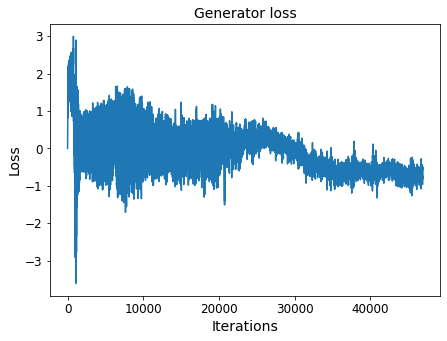

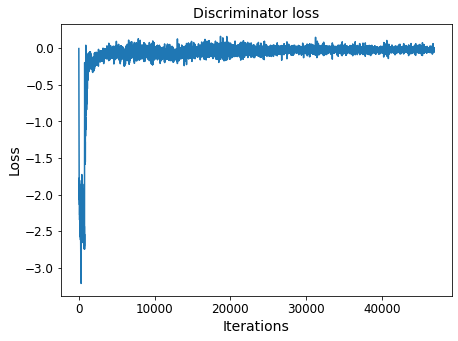

In [16]:
# ====
# your code
# choose these parameters
BATCH_SIZE       = 32   # any adequate value
DIM              = 64   # > 32
N_EPOCHS         = 30   # > 20 
CRITIC_STEPS     = 1    # 1 < x < 10
POWER_ITERATIONS = 5    # 1 < x < 5
LR               = 5e-5 # < 1e-3
# ====

# this path for saving checkpoints, change it if you want
#CKPT_PATH = '/content/drive/MyDrive/DGM_HW6_SNGAN_ckpt/'
CKPT_PATH = './DGM_HW6_SNGAN_ckpt/'
if not os.path.exists(CKPT_PATH):
    os.makedirs(CKPT_PATH)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
print('Total number of epochs:', N_EPOCHS)

generator = ConvGenerator(n_channels=DIM).cuda()
critic = ConvCritic(n_channels=DIM, power_iterations=POWER_ITERATIONS).cuda()

train_losses = train_sngan(
    generator, 
    critic, 
    train_loader,
    CRITIC_STEPS, 
    BATCH_SIZE, 
    N_EPOCHS,
    LR,
    USE_CUDA,
    CKPT_PATH
)

g_losses = train_losses['generator_losses']
d_losses = train_losses['discriminator_losses']

plot_losses(g_losses, 'Generator loss')
plot_losses(d_losses, 'Discriminator loss')

Let sample from our model and draw the samples.

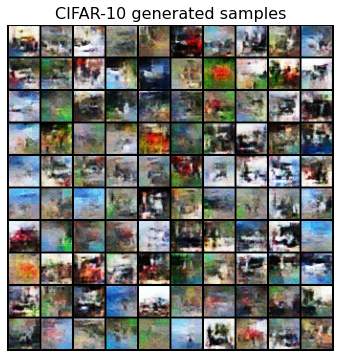

In [17]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    

show_samples(samples[:100], title='CIFAR-10 generated samples')

# Task 3: Inception Score and FID (5pt)

Here our goal is to understand how to evaluate likelihood-free models using [Inception Score](https://arxiv.org/pdf/1606.03498.pdf) and [Frechet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf).

In [18]:
# this is a helper function that we will use further
def resize_tensor(x, image_size):
    return F.interpolate(x, size=(image_size, image_size), mode='bilinear', align_corners=False)

## Inception Score

The formula for Inception Score is
$$
    \text{IS} = \exp \bigl( \mathbb{E}_{\mathbf{x}} KL(p(y | \mathbf{x}) || p(y)) \bigr),
$$

where 
* $p(y | \mathbf{x})$ is a pretrained classification model with labels $y$ (we will use [Inception V3 model](https://pytorch.org/vision/main/generated/torchvision.models.inception_v3.html));
* $p(y) = \int p(y | \mathbf{x}) p(\mathbf{x}) d \mathbf{x}$ is a marginal distribution on labels.

Let initialize our classification model.

In [19]:
inception_model = inception_v3(pretrained=True)

if USE_CUDA:
    inception_model = inception_model.cuda()

inception_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

We need to get class probabilities from our classification model.

In [20]:
def get_inception_probs(x, model, image_size):
    x = resize_tensor(x, image_size=image_size)
    # ====
    # your code
    # apply model and get probs (apply softmax)
    probs = torch.softmax(model.forward(x), dim=-1)
    # ====
    return probs.data.cpu().numpy()


def test_get_inception_probs():
    x = torch.zeros(size=(1, 3, 10, 10))
    if USE_CUDA:
        x = x.cuda()
    probs = get_inception_probs(x, inception_model, image_size=299)
    true_probs = np.array([
        0.0006735109, 0.0003643963, 0.00030289646, 0.00031744016, 0.0005638504, 
        0.0006541903, 0.00016877, 0.0004070145,  0.00030033154, 0.0005093196
    ])
    assert np.allclose(probs[0, :10], true_probs)


test_get_inception_probs()

In [21]:
# this is a helper function that generates samples from the generator
def generate_fake_images(generator, n_samples, batch_size):
    fake_images = []
    for i in range(n_samples // batch_size):
        fake_samples = generator.sample(batch_size).cpu().detach().numpy()
        fake_images.extend(fake_samples)

    fake_samples = generator.sample(n_samples % batch_size).cpu().detach().numpy()
    fake_images.extend(fake_samples)
    return np.array(fake_images)

It is the main function for getting Inception Score.

In [22]:
from scipy.stats import entropy

USE_CUDA = False

def get_inception_score(generator, inception_model, n_samples, batch_size=32, splits=10):
    if USE_CUDA:
        generator       = generator      .cuda()
        inception_model = inception_model.cuda()
    else:
        generator       = generator      .cpu()
        inception_model = inception_model.cpu()
    
    generator      .eval()
    inception_model.eval()
    
    mean_s = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    std_s  = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    image_size = 299
        
    fake_images_numpy = generate_fake_images(generator, n_samples, batch_size)
    fake_images_numpy = (fake_images_numpy - mean_s)/std_s
    
    loader = torch.utils.data.DataLoader(fake_images_numpy, batch_size=batch_size)

    # ====
    # your code
    # get probs of size [n_samples x 1000] for the fake_samples
    prob_ss = []
    for fake_batch_torch in tqdm(loader):
        fake_batch_torch = fake_batch_torch.float()
        if USE_CUDA:
            fake_batch_torch = fake_batch_torch.cuda()
        else:
            fake_batch_torch = fake_batch_torch.cpu ()
        prob_s = get_inception_probs(fake_batch_torch, inception_model, image_size)
        prob_ss.append( prob_s )
    prob_ss = np.concatenate(prob_ss, axis=0)
    # ====
    
    eps = 1e-10
    split_scores = []

    for k in range(splits):
        p_yx = prob_ss[k * (n_samples // splits): (k + 1) * (n_samples // splits), :]
        # ====
        # your code
        # 1) calculate p_y mean value of the current part
        # 2) calculate KL (use could you entropy function from scipy)
        # 3) exponentiate it
        
        p_y = p_yx.mean(axis=0, keepdims=True)
        p_y = np.broadcast_to(p_y, p_yx.shape)
        
        split_score = np.exp( np.mean( entropy(p_yx, p_y) ) )
        # ====
        split_scores.append(split_score)

    return np.mean(split_scores)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

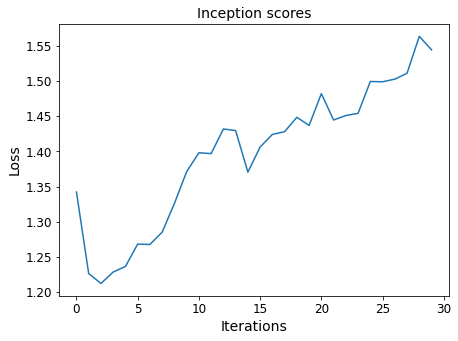

In [23]:
N_SAMPLES = 1000
BATCH_SIZE = 16
SPLITS = 5

inception_scores = []
for epoch in range(N_EPOCHS):
    ckpt_path = os.path.join(CKPT_PATH, f'ckpt_epoch_{epoch}.pt')
    generator.load_state_dict(torch.load(ckpt_path))
    inception_score = get_inception_score(
        generator=generator,
        inception_model=inception_model,
        n_samples=N_SAMPLES,
        batch_size=BATCH_SIZE,
        splits=SPLITS
    )
    inception_scores.append(inception_score)

plot_losses(inception_scores, 'Inception scores')

You have to see increasing trend of the Inception Score. The score > 1.5 is good enough for this task.

## Frechet Inception Distance

Now we will implement Frechet Inception Distance:

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* Representations are the outputs of the intermediate layer from the pretrained classification model (we will use the last layer activations).
* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ are the mean vector and the covariance matrix of feature representations for samples from $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ are the mean vector and the covariance matrix of feature representations for samples from $p(\mathbf{x} | \boldsymbol{\theta})$.

Let implement function to take square root of matrix (we need it for the formula above).

In [24]:
# this is a helper function, do not change
def get_matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

Not let implement the function to calculate the distance (it is just the formula above).

In [25]:
def get_distance(mu_x, mu_y, sigma_x, sigma_y):
    # ====
    # your code
    distance = torch.sum((mu_x - mu_y)*(mu_x - mu_y)) + torch.trace(sigma_x + sigma_y - 2*get_matrix_sqrt(sigma_x*sigma_y) )
    # ====
    return distance

def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    dist = get_distance(mu_x, mu_y, sigma_x, sigma_y)
    assert np.isclose(dist, 243.7621)


test_get_distance()

Let implement the function which calculate intermediate representations for real and fake samples.

In [26]:
def get_features(generator, inception_model, loader, n_samples, batch_size, image_size):
    if USE_CUDA:
        generator       = generator      .cuda()
        inception_model = inception_model.cuda()
    else:
        generator       = generator      .cpu ()
        inception_model = inception_model.cpu ()
        
    generator.eval()
    inception_model.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples in loader: 
            real_samples = resize_tensor(real_samples, image_size) 
            if USE_CUDA:
                real_samples = real_samples.cuda()
            # ====
            # your code
            # get features of real samples
            real_features = inception_model.forward(real_samples)
            # ====
            real_features_list.append(real_features)

            fake_samples = generator.sample(len(real_samples))
            fake_samples = resize_tensor(fake_samples, image_size)
            if USE_CUDA:
                fake_samples = fake_samples.cuda()
            # ====
            # your code
            # get features of fake samples
            fake_features = inception_model.forward(fake_samples)
            # ====
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

In [27]:
# this is a helper function, do not change
def calcuate_stats(fake_features, real_features):
    
    def get_covariance(features):
        return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))
    
    mu_fake = fake_features.mean(0)
    mu_real = real_features.mean(0)
    sigma_fake = get_covariance(fake_features)
    sigma_real = get_covariance(real_features)
    return mu_fake, mu_real, sigma_fake, sigma_real

Now we are ready to implement the main function for getting FID.

In [28]:
def get_frechet_inception_distance(generator, inception_model, loader, n_samples, batch_size, image_size):
    # ====
    # your code
    # 1) get features 
    # 2) calculate stats
    # 3) get distance
    fake_features_all, real_features_all = get_features(generator, inception_model, loader, n_samples, batch_size, image_size)
    mu_fake, mu_real, sigma_fake, sigma_real = calcuate_stats(fake_features_all, real_features_all)
    return get_distance(mu_fake, mu_real, sigma_fake, sigma_real)
    # ====

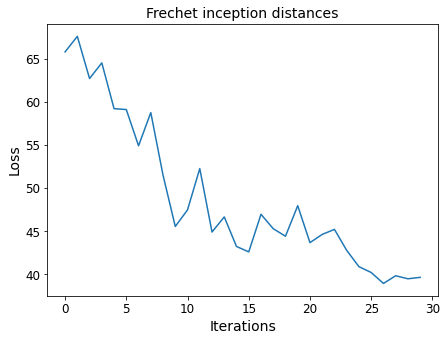

In [29]:
N_SAMPLES = 512
BATCH_SIZE = 4 # samples per iteration
IMAGE_SIZE = 76 


fids = []
for epoch in range(N_EPOCHS):
    loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    ckpt_path = os.path.join(CKPT_PATH, f'ckpt_epoch_{epoch}.pt')
    generator.load_state_dict(torch.load(ckpt_path))
    fid = get_frechet_inception_distance(
        generator=generator, 
        inception_model=inception_model, 
        loader=loader, 
        n_samples=N_SAMPLES, 
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE
    )
    fids.append(fid)

plot_losses(fids, 'Frechet inception distances')

FID should has decreasing trend. The value < 60 is ok for this task.